(3, 1)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (None, 1, 128)            512       
                                                                 
 Dropout_C_1 (Dropout)       (None, 1, 128)            0         
                                                                 
 Flatten (Flatten)           (None, 128)               0         
                                                                 
 Dense_4 (Dense)             (None, 32)                4128      
                                                                 
 Output (Dense)              (None, 1)                 33        
                                                                 
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/300
Epoch 2/300
Epoch 3/300
Epoc

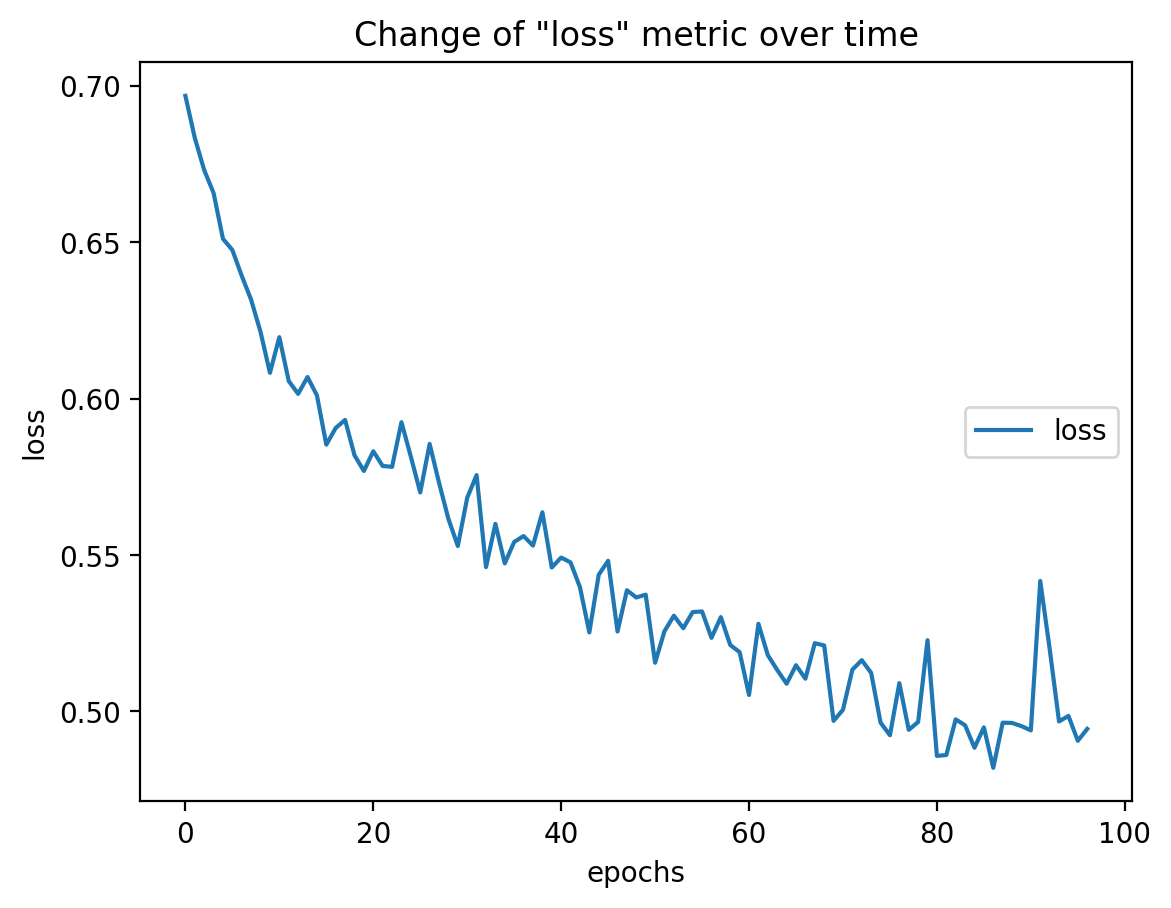

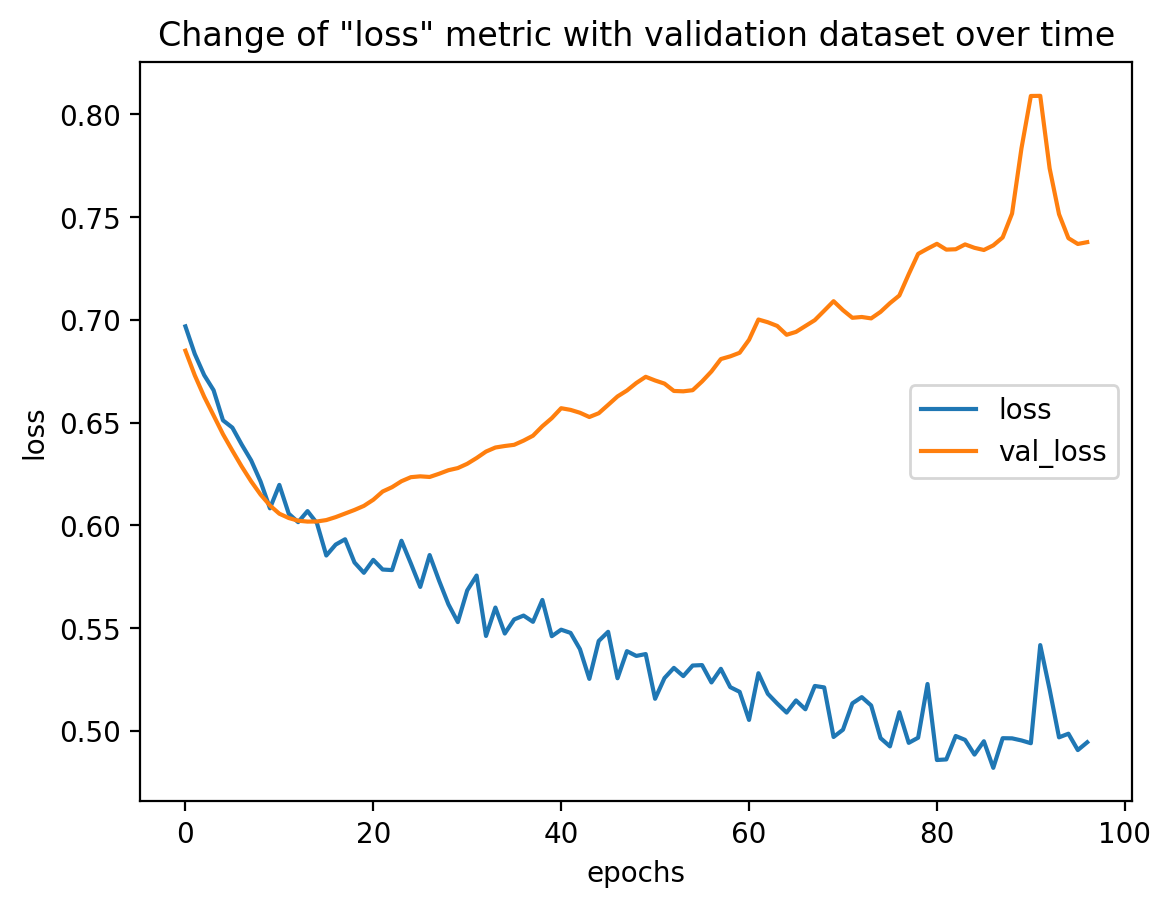

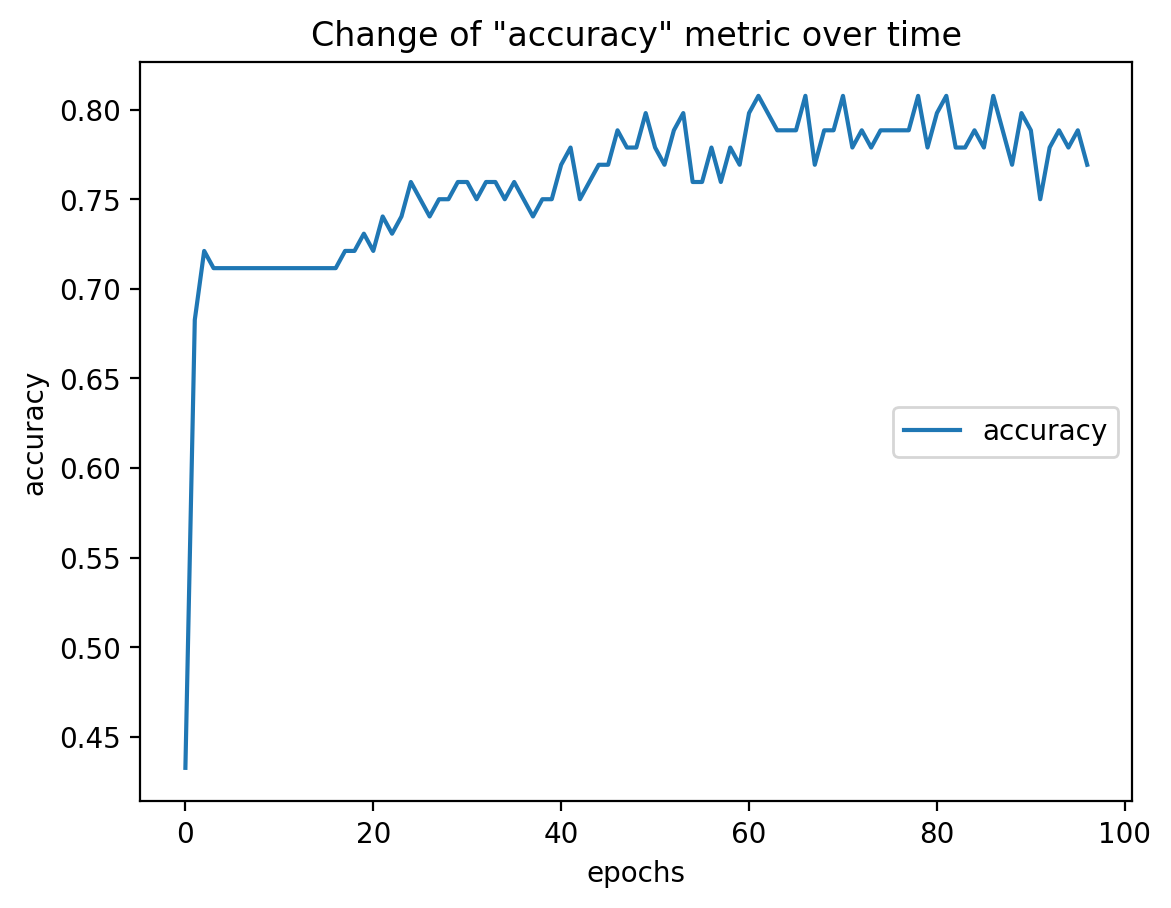

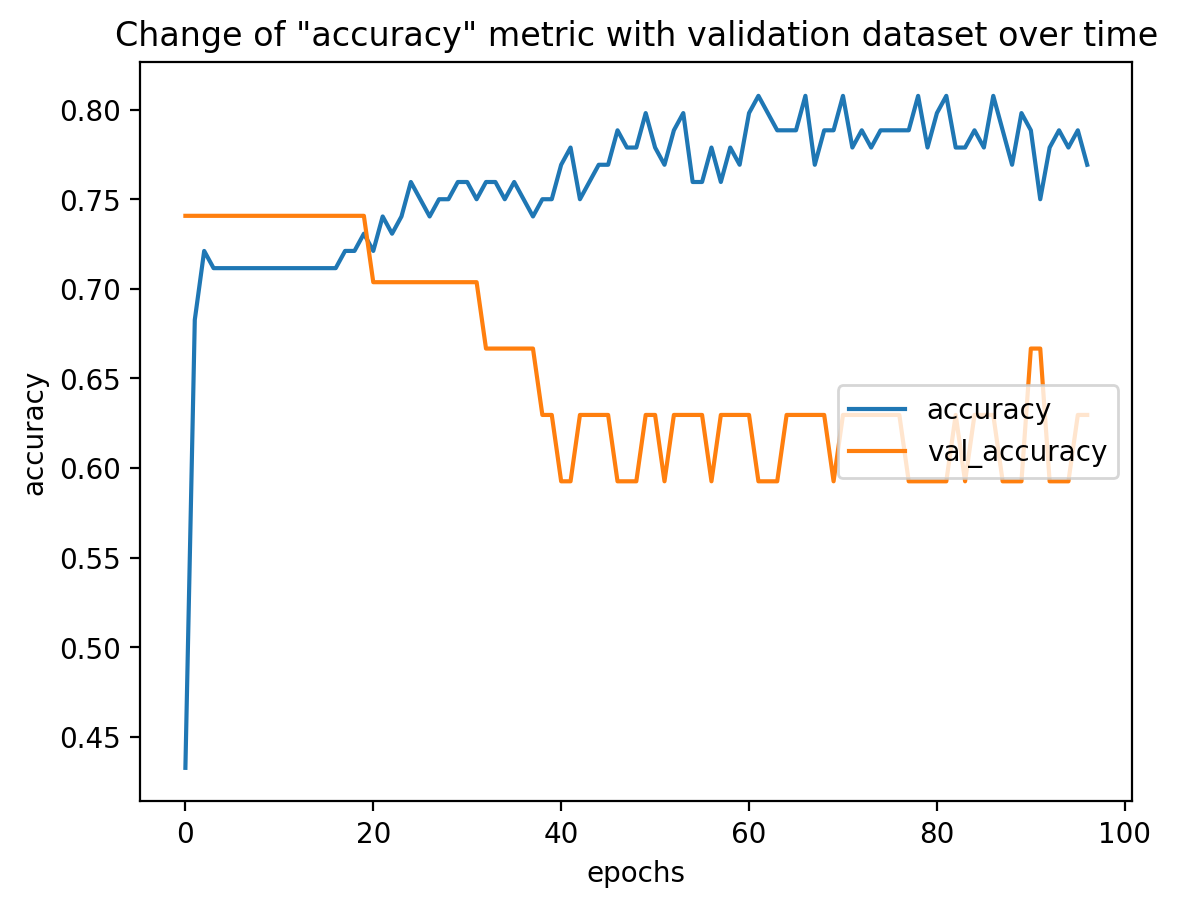


Confusion Matrix:
	---------------------------------
	|	16	|	4	| 
	---------------------------------
	|	6	|	1	|
	---------------------------------

TruePositive	:	16
TrueNegative	:	1
FalsePositive	:	4
FalseNegative	:	6


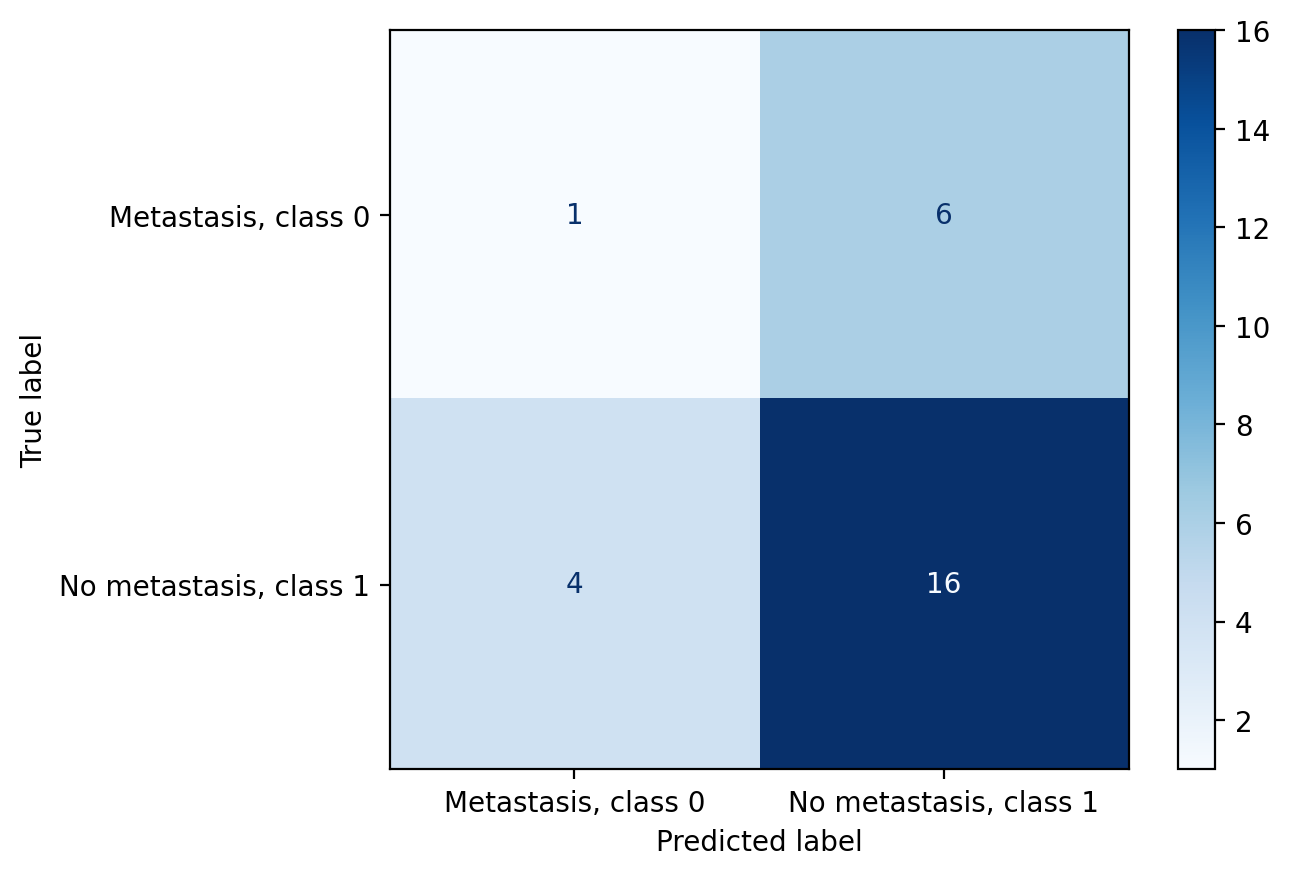

                        precision    recall  f1-score   support

   Metastasis, class 0       0.20      0.14      0.17         7
No metastasis, class 1       0.73      0.80      0.76        20

              accuracy                           0.63        27
             macro avg       0.46      0.47      0.46        27
          weighted avg       0.59      0.63      0.61        27



In [11]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

# Wczytanie danych
data = np.genfromtxt("../../data/labels_features.csv", delimiter=",")
data = data[1:, :]

LABELS = data[:, 1].astype(int)  # Tylko klasyfikacja real/fake
FEATURES = data[:, 2:]  # Tylko cechy, bez klasyfikacji
TARGET_NAMES = ["Metastasis, class 0", "No metastasis, class 1"]

# Definiowanie modelu bazowego do selekcji cech
model_rf = RandomForestClassifier(random_state=42)

# Użycie RFECV do automatycznego doboru liczby cech
selector = RFECV(estimator=model_rf, step=1, cv=5, scoring='accuracy')
FEATURES = selector.fit_transform(FEATURES, LABELS)

# Podział na zbiory treningowe i testowe
test_size = 0.33
x_train, x_test, y_train, y_test = train_test_split(FEATURES, LABELS, test_size=test_size, random_state=42)

# Konwersja etykiet do formatu kategorycznego
num_labels = len(np.unique(LABELS))
y_cat_train = to_categorical(y_train, num_labels)
y_cat_test = to_categorical(y_test, num_labels)

# Skalowanie cech
scaler_object = MinMaxScaler()
scaler_object.fit(x_train)
x_train = scaler_object.transform(x_train)
x_test = scaler_object.transform(x_test)

# Przekształcenie cech dla modelu
x_train = x_train.reshape(*x_train.shape, 1)
x_test = x_test.reshape(*x_test.shape, 1)

x_train_shape = x_train[0].shape
x_test_shape = x_test[0].shape
print(x_train_shape)

# Tworzenie modelu
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, input_shape=x_train_shape, activation="relu", name="Conv1D_1"))
model.add(Dropout(0.5, name="Dropout_C_1"))
model.add(Flatten(name="Flatten"))
model.add(Dense(32, activation="relu", name="Dense_4"))
model.add(Dense(1, activation="sigmoid", name="Output"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

print(model.summary())

epochs = 300
withVal = True

# Callbacki
monitor = "loss"
checkpoint = ModelCheckpoint("../../models/feature_selection/wrapper_method_best_model.h5", monitor=monitor, save_best_only=True, mode="auto")
early_stopping = EarlyStopping(monitor=monitor, patience=10, restore_best_weights=True)

trainData = x_train
testData = x_test

if withVal:
    results = model.fit(trainData, y_train, epochs=epochs, verbose=3, validation_data=(testData, y_test), callbacks=[checkpoint, early_stopping])
else:
    results = model.fit(x_train, y_train, epochs=epochs, verbose=3)

metric_names = model.metrics_names
scores = model.evaluate(testData, y_test, verbose=0)

print("Metrics:")
for i, name in enumerate(metric_names):
    print("\t%s:   \t%.2f" % (name, scores[i]))

def plot_metric(metric: str, withVal: bool = False) -> None:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.xlabel("epochs")
    plt.ylabel(metric)

    ax.plot(results.history[metric], label=metric)
    if withVal:
        plt.title(f'Change of "{str(metric)}" metric with validation dataset over time')
        ax.plot(results.history["val_" + str(metric)], label="val_" + str(metric))
    else:
        plt.title(f'Change of "{metric}" metric over time')
    plt.legend(loc="center right")
    plt.show(block=False)

for name in metric_names:
    plot_metric(name)
    if withVal:
        plot_metric(name, withVal)

predictions = (model.predict(testData, verbose=0) > 0.5).astype("int32")

conf_mat = confusion_matrix(y_test, predictions)
confusion = {
    "TruePositive": conf_mat[1][1],
    "TrueNegative": conf_mat[0][0],
    "FalsePositive": conf_mat[1][0],
    "FalseNegative": conf_mat[0][1],
}
accuracy = scores[1]
accuracy = round(accuracy * 100, 2)

def printDict(obj: dict[str, int] = "") -> None:
    if isinstance(obj, dict):
        for k, v in obj.items():
            if hasattr(v, "__iter__"):
                print(k)
                printDict(v)
            else:
                print("%s\t:\t%s" % (k, v))
    elif isinstance(obj, list):
        for v in obj:
            if hasattr(v, "__iter__"):
                printDict(v)
            else:
                print(v)
    else:
        print(obj)

separator = "\t---------------------------------\n"
matrixConfusion = f'\nConfusion Matrix:\n{separator}\t|\t{confusion["TruePositive"]}\t|\t{confusion["FalsePositive"]}\t| \n{separator}\t|\t{confusion["FalseNegative"]}\t|\t{confusion["TrueNegative"]}\t|\n{separator}'
print(matrixConfusion)
printDict(confusion)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=TARGET_NAMES)
disp.plot(cmap=plt.cm.Blues)
plt.show()

report = classification_report(y_test, predictions, target_names=TARGET_NAMES)
print(report)


In [12]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (Conv1D)           (None, 1, 128)            512       
                                                                 
 Dropout_C_1 (Dropout)       (None, 1, 128)            0         
                                                                 
 Flatten (Flatten)           (None, 128)               0         
                                                                 
 Dense_4 (Dense)             (None, 32)                4128      
                                                                 
 Output (Dense)              (None, 1)                 33        
                                                                 
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________
